In [2]:
pip install gymnasium numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import and smoke test

In [3]:
# Import 
import os, json, random
from collections import defaultdict, deque
from typing import Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from environment3 import LifeStyleEnv  # make sure this file is in the same folder

# quick smoke test (check environment)
env = LifeStyleEnv()
obs, info = env.reset(seed=42)
print("Action space:", env.action_space)
print("Observation keys:", list(obs.keys()))
env.close()


Action space: Discrete(9)
Observation keys: ['current_weight_kg', 'current_bmi', 'current_stress_level', 'current_hunger_level', 'current_energy_level', 'daily_calories_burned', 'daily_calories_intake', 'daily_protein_intake', 'daily_fat_intake', 'daily_saturated_fat_intake', 'daily_carbs_intake', 'daily_fiber_intake', 'daily_calories_needed', 'current_timeslot', 'day_of_episode', 'time_since_last_meal', 'time_since_last_exercise']


# State Representation

In [4]:
# State Representation (binning helpers)
def _bin5(x: float, lo: float = 0.0, hi: float = 100.0) -> int:
    x = float(x)
    x = max(lo, min(hi, x))
    width = (hi - lo) / 5.0 if hi > lo else 1.0
    return min(4, int((x - lo) / width))

def _bin_bmi(bmi: float) -> int:
    b = float(bmi)
    if b < 16:  return 0
    if b < 18.5:return 1
    if b < 22:  return 2
    if b < 25:  return 3
    if b < 27:  return 4
    if b < 30:  return 5
    if b < 35:  return 6
    return 7  # >=35

def state_key(obs: Dict) -> Tuple[int, int, int, int, int]:
    bmi    = float(obs["current_bmi"][0])
    stress = float(obs["current_stress_level"][0])
    energy = float(obs["current_energy_level"][0])
    hunger = float(obs["current_hunger_level"][0])
    tslot  = int(obs["current_timeslot"])   # 0..23
    tbin   = tslot // 3                     # 8 bins (3h blocks)
    return (_bin_bmi(bmi), _bin5(stress), _bin5(energy), _bin5(hunger), tbin)

# Action mask getter
def get_valid_mask(env: LifeStyleEnv) -> np.ndarray:
    if hasattr(env, "action_masks"):
        m = env.action_masks()
    elif hasattr(env, "get_action_mask"):
        m = env.get_action_mask()
    else:
        m = np.ones(env.action_space.n, dtype=bool)
    return np.asarray(m, dtype=bool)

# Q-table save/load
def save_q(Q: Dict[Tuple, float], path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    payload = {str(k): float(v) for k, v in Q.items()}
    with open(path, "w") as f:
        json.dump(payload, f)

def load_q(path: str) -> Dict[Tuple, float]:
    data = json.load(open(path))
    return {eval(k): v for k, v in data.items()}

# Action name mapping (for readability)
ACTION_NAME = {
    0: "meal: light", 1: "meal: medium", 2: "meal: heavy",
    3: "exercise: light", 4: "exercise: moderate", 5: "exercise: intense",
    6: "rest: light", 7: "rest: deep", 8: "skip",
}


# Random Baseline

In [5]:
def eval_random_masked(episodes=5, seed=123):
    scores = []
    for k in range(episodes):
        env = LifeStyleEnv()
        obs, info = env.reset(seed=seed+k)
        done, ep_ret = False, 0.0
        while not done:
            # use action mask if available
            mask = env.action_masks() if hasattr(env,"action_masks") else np.ones(env.action_space.n, dtype=bool)
            valid = np.where(mask)[0]
            a = int(np.random.choice(valid)) if len(valid) else 0
            obs, r, term, trunc, _ = env.step(a)
            ep_ret += float(r)
            done = bool(term or trunc)
        env.close()
        scores.append(ep_ret)
    return float(np.mean(scores)), float(np.std(scores))

# Run baseline
rand_mean, rand_std = eval_random_masked(episodes=5)
print(f"Random (mask-aware) baseline: mean={rand_mean:.2f} ± {rand_std:.2f}")


Random (mask-aware) baseline: mean=12091.99 ± 1007.09


# Greedy evaluator

In [6]:
# Greedy Evaluation Function
def evaluate_greedy(Q: Dict[Tuple, float], episodes: int = 3, seed: int = 123) -> float:
    scores = []
    for k in range(episodes):
        env = LifeStyleEnv()
        obs, info = env.reset(seed=seed + k)
        s = state_key(obs); done = False; ep_ret = 0.0
        while not done:
            valid = get_valid_mask(env)
            idx = np.where(valid)[0]
            a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0
            obs2, r, term, trunc, info = env.step(a)
            s, ep_ret, done = state_key(obs2), ep_ret + float(r), bool(term or trunc)
        env.close()
        scores.append(ep_ret)
    return float(np.mean(scores))


# Exploration strategies & action picker

In [7]:
from enum import Enum

class Explore(Enum):
    EPS_DECAY = 1
    EPS_FIXED = 2
    SOFTMAX   = 3
    UCB       = 4

def pick_action_explore(
    Q: Dict[Tuple, float],
    s: Tuple[int, ...],
    env: LifeStyleEnv,
    valid_mask: np.ndarray,
    n_actions: int,
    ep_idx: int,
    *,
    strategy: Explore,
    eps: float,
    eps_end: float,
    eps_decay: float,
    tau: float,
    ucb_counts: dict,
    ucb_c: float,
    total_ucb_steps: int
) -> int:
    """Choose an action among valid ones according to the exploration strategy."""
    valid_idx = np.where(valid_mask)[0]
    if len(valid_idx) == 0:
        return int(np.random.randint(n_actions))

    if strategy == Explore.EPS_DECAY:
        # epsilon supplied from caller; caller will decay it each episode
        if np.random.rand() < eps:
            return int(np.random.choice(valid_idx))
        # greedy among valid
        return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))

    if strategy == Explore.EPS_FIXED:
        # use eps_end as the fixed epsilon
        if np.random.rand() < eps_end:
            return int(np.random.choice(valid_idx))
        return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))

    if strategy == Explore.SOFTMAX:
        # Boltzmann/Softmax over Q-values on valid actions
        qvals = np.array([Q.get((s, int(a)), 0.0) for a in valid_idx], dtype=float)
        # numerical stability
        z = (qvals / max(tau, 1e-6))
        z = z - z.max()
        probs = np.exp(z)
        probs /= probs.sum() if probs.sum() > 0 else 1.0
        choice = int(np.random.choice(np.arange(len(valid_idx)), p=probs))
        return int(valid_idx[choice])

    if strategy == Explore.UCB:
        # Upper Confidence Bound: Q + c * sqrt( ln(t) / (N(s,a)+1) )
        t = max(total_ucb_steps, 1)
        best_a, best_score = None, -1e18
        for a in valid_idx:
            n_sa = ucb_counts.get((s, int(a)), 0)
            bonus = ucb_c * np.sqrt(np.log(t) / (n_sa + 1.0))
            score = Q.get((s, int(a)), 0.0) + bonus
            if score > best_score:
                best_score, best_a = score, int(a)
        return int(best_a)

    # default fallback: greedy among valid
    return int(max(valid_idx, key=lambda a: Q.get((s, int(a)), 0.0)))


# Dyna-Q trainer

In [8]:
def train_dyna_q_explore(episodes: int = 250,
                         alpha: float = 0.10,
                         gamma: float = 0.99,
                         eps_start: float = 1.0,
                         eps_end: float = 0.05,
                         eps_decay: float = 0.995,
                         planning_steps: int = 12,
                         model_cap: int = 20000,
                         seed: int = 42,
                         eval_every: int = 20,
                         best_path: str = "saved_models/dyna_q_best.json",
                         strategy: Explore = Explore.EPS_DECAY,
                         tau: float = 1.0,
                         ucb_c: float = 1.4):
    """
    Dyna-Q with pluggable exploration strategies.
    """
    random.seed(seed); np.random.seed(seed)
    env = LifeStyleEnv()
    nA = env.action_space.n

    Q = defaultdict(float)
    model = {}                     # (s,a) -> (s', r)
    seen_pairs = deque(maxlen=model_cap)

    returns = []
    epsilon = eps_start
    best_eval = -float("inf")

    # UCB stats
    ucb_counts = {}
    total_steps = 0

    for ep in range(1, episodes + 1):
        obs, info = env.reset(seed=seed + ep)
        s = state_key(obs); done = False; ep_ret = 0.0

        while not done:
            valid = get_valid_mask(env)

            a = pick_action_explore(
                Q, s, env, valid, nA, ep,
                strategy=strategy,
                eps=epsilon,
                eps_end=eps_end,
                eps_decay=eps_decay,
                tau=tau,
                ucb_counts=ucb_counts,
                ucb_c=ucb_c,
                total_ucb_steps=total_steps + 1
            )

            obs2, r, terminated, truncated, info = env.step(int(a))
            s2 = state_key(obs2)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            total_steps += 1

            # UCB bookkeeping
            if strategy == Explore.UCB:
                ucb_counts[(s, int(a))] = ucb_counts.get((s, int(a)), 0) + 1

            # Real TD update (mask-aware on s')
            valid_next = get_valid_mask(env)
            idx_next = np.where(valid_next)[0]
            max_next = max((Q[(s2, int(a2))] for a2 in idx_next), default=0.0)

            Q[(s, a)] += alpha * (r + gamma * max_next - Q[(s, a)])

            # Model + planning
            key = (s, a)
            model[key] = (s2, float(r))
            seen_pairs.append(key)

            for _ in range(planning_steps):
                sp, ap = random.choice(seen_pairs)
                sp2, rp = model[(sp, ap)]
                max_p = max(Q[(sp2, a2)] for a2 in range(nA))
                Q[(sp, ap)] += alpha * (rp + gamma * max_p - Q[(sp, ap)])

            s = s2

        returns.append(ep_ret)

        # Epsilon schedule (only for EPS_DECAY)
        if strategy == Explore.EPS_DECAY:
            epsilon = max(eps_end, epsilon * eps_decay)

        if ep % eval_every == 0:
            score = evaluate_greedy(Q, episodes=3, seed=777)
            if score > best_eval:
                best_eval = score
                save_q(Q, best_path)
            avg10 = float(np.mean(returns[-min(10, len(returns)):] ))
            print(f"{strategy.name:>9} | ep {ep:04d} | last10={avg10:8.2f} | "
                  f"eval={score:8.2f} | best={best_eval:8.2f} | eps={epsilon:5.3f}")

    env.close()
    return Q, np.asarray(returns, dtype=float)


# Training Run (ε-decay default) & learning-curve plot

EPS_DECAY | ep 0020 | last10=13395.67 | eval=16767.49 | best=16767.49 | eps=0.905
EPS_DECAY | ep 0040 | last10=13987.38 | eval=18765.02 | best=18765.02 | eps=0.818
EPS_DECAY | ep 0060 | last10=15181.60 | eval= 5880.91 | best=18765.02 | eps=0.740
EPS_DECAY | ep 0080 | last10=12399.18 | eval= 8340.70 | best=18765.02 | eps=0.670
EPS_DECAY | ep 0100 | last10=11548.20 | eval= 9075.63 | best=18765.02 | eps=0.606
EPS_DECAY | ep 0120 | last10=14045.22 | eval= 5240.65 | best=18765.02 | eps=0.548
EPS_DECAY | ep 0140 | last10=11778.99 | eval= 7542.63 | best=18765.02 | eps=0.496
EPS_DECAY | ep 0160 | last10=10302.76 | eval=10277.49 | best=18765.02 | eps=0.448
EPS_DECAY | ep 0180 | last10=10611.20 | eval= 6269.22 | best=18765.02 | eps=0.406
EPS_DECAY | ep 0200 | last10= 9924.75 | eval= 5948.00 | best=18765.02 | eps=0.367
EPS_DECAY | ep 0220 | last10=10097.40 | eval= 8205.78 | best=18765.02 | eps=0.332
EPS_DECAY | ep 0240 | last10= 8758.76 | eval= 4533.34 | best=18765.02 | eps=0.300
✅ training finis

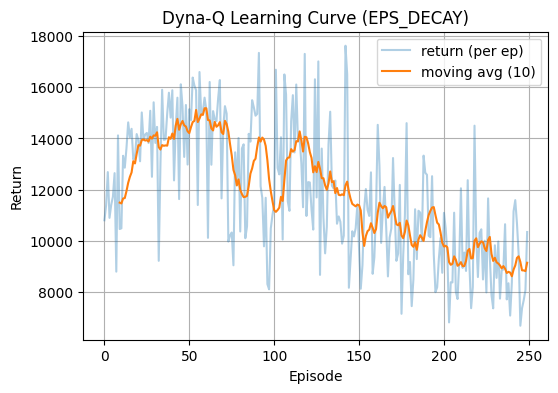

In [9]:
EPISODES = 250
PLANNING = 15
ALPHA = 0.10
EVAL_EVERY = 20

Q, returns = train_dyna_q_explore(
    episodes=EPISODES,
    planning_steps=PLANNING,
    alpha=ALPHA,
    eval_every=EVAL_EVERY,
    best_path="saved_models/dyna_q_best.json",
    strategy=Explore.EPS_DECAY
)
print("✅ training finished")

# Plot learning curve
plt.figure(figsize=(6,4))
win = 10
if len(returns) >= win:
    mov = np.convolve(returns, np.ones(win)/win, mode='valid')
    plt.plot(returns, alpha=0.35, label='return (per ep)')
    plt.plot(np.arange(win-1, win-1+len(mov)), mov, label=f'moving avg ({win})')
else:
    plt.plot(returns, label='return (per ep)')
plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Dyna-Q Learning Curve (EPS_DECAY)')
plt.legend(); plt.grid(True); plt.show()


 # Greedy Day-1 Plan & Metrics Visualization

Greedy Day-1 plan (hour → action)
00:00 → skip
01:00 → skip
02:00 → skip
03:00 → skip
04:00 → skip
05:00 → skip
06:00 → rest: deep
07:00 → meal: light
08:00 → exercise: moderate
09:00 → rest: light
10:00 → skip
11:00 → skip
12:00 → meal: medium
13:00 → skip
14:00 → skip
15:00 → skip
16:00 → skip
17:00 → skip
18:00 → rest: deep
19:00 → exercise: intense
20:00 → rest: light
21:00 → exercise: intense
22:00 → skip
23:00 → skip


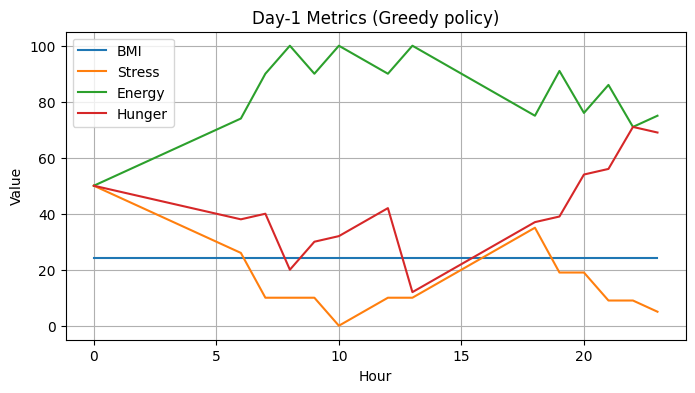

In [10]:
def greedy_day_plan(Q: Dict[Tuple, float], seed: int = 123):
    env = LifeStyleEnv()
    obs, info = env.reset(seed=seed)
    s = state_key(obs); done = False

    timeline: List[int] = []
    metrics = {"Hour": [], "BMI": [], "Stress": [], "Energy": [], "Hunger": []}

    while not done and len(timeline) < 24:  # first day only
        valid = get_valid_mask(env)
        idx = np.where(valid)[0]
        a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0))) if len(idx) else 0

        # log before step
        metrics["Hour"].append(int(obs["current_timeslot"]))
        metrics["BMI"].append(float(obs["current_bmi"][0]))
        metrics["Stress"].append(float(obs["current_stress_level"][0]))
        metrics["Energy"].append(float(obs["current_energy_level"][0]))
        metrics["Hunger"].append(float(obs["current_hunger_level"][0]))
        timeline.append(a)

        obs2, r, term, trunc, info = env.step(a)
        s, obs, done = state_key(obs2), obs2, bool(term or trunc)
    env.close()
    return timeline, metrics

timeline, metrics = greedy_day_plan(Q, seed=321)

print("Greedy Day-1 plan (hour → action)")
for h, a in zip(metrics["Hour"], timeline):
    print(f"{h:02d}:00 → {ACTION_NAME[a]}")

plt.figure(figsize=(8,4))
for k in ["BMI","Stress","Energy","Hunger"]:
    plt.plot(metrics["Hour"], metrics[k], label=k)
plt.xlabel("Hour"); plt.ylabel("Value"); plt.title("Day-1 Metrics (Greedy policy)")
plt.legend(); plt.grid(True); plt.show()


# Save Q & quick baseline vs learned comparison

In [11]:
# Save the latest table
save_q(Q, "saved_models/dyna_q_table.json")
print("Saved final Q-table to saved_models/dyna_q_table.json")

# Random vs. Dyna-Q comparison
rand_mean, rand_std = eval_random_masked(episodes=10, seed=123)
dq_mean = evaluate_greedy(Q, episodes=10, seed=777)

print("=== Baseline vs Learned (Greedy) ===")
print(f"Random (mask-aware)   : mean = {rand_mean:.2f} ± {rand_std:.2f}")
print(f"Dyna-Q (greedy policy): mean = {dq_mean:.2f}")


Saved final Q-table to saved_models/dyna_q_table.json
=== Baseline vs Learned (Greedy) ===
Random (mask-aware)   : mean = 11824.53 ± 1065.47
Dyna-Q (greedy policy): mean = 6047.51


#  Exploration strategies (ε-decay, Softmax, UCB) + overlay plot + table

EPS_DECAY | ep 0020 | last10=13395.67 | eval=16767.49 | best=16767.49 | eps=0.905
EPS_DECAY | ep 0040 | last10=13987.38 | eval=18765.02 | best=18765.02 | eps=0.818
EPS_DECAY | ep 0060 | last10=15181.60 | eval= 5880.91 | best=18765.02 | eps=0.740
EPS_DECAY | ep 0080 | last10=12399.18 | eval= 8340.70 | best=18765.02 | eps=0.670
EPS_DECAY | ep 0100 | last10=11548.20 | eval= 9075.63 | best=18765.02 | eps=0.606
EPS_DECAY | ep 0120 | last10=14045.22 | eval= 5240.65 | best=18765.02 | eps=0.548
EPS_DECAY | ep 0140 | last10=11778.99 | eval= 7542.63 | best=18765.02 | eps=0.496
EPS_DECAY | ep 0160 | last10=10302.76 | eval=10277.49 | best=18765.02 | eps=0.448
EPS_DECAY | ep 0180 | last10=10611.20 | eval= 6269.22 | best=18765.02 | eps=0.406
  SOFTMAX | ep 0020 | last10=12195.28 | eval=12195.29 | best=12195.29 | eps=1.000
  SOFTMAX | ep 0040 | last10=12195.28 | eval=12195.29 | best=12195.29 | eps=1.000
  SOFTMAX | ep 0060 | last10=12195.28 | eval=12195.29 | best=12195.29 | eps=1.000
  SOFTMAX | ep 0

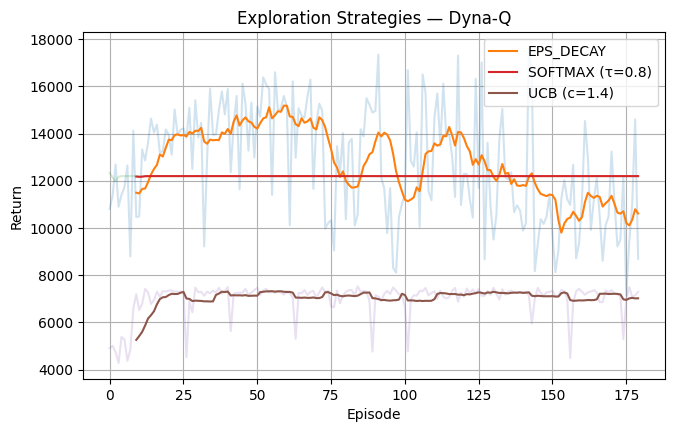

=== Final Evaluation (10 episodes, greedy) ===
EPS_DECAY         : 6269.22
SOFTMAX (τ=0.8)   : 12195.29
UCB (c=1.4)       : 7479.25


In [12]:
# Train three strategies
Q_eps, rets_eps = train_dyna_q_explore(strategy=Explore.EPS_DECAY, episodes=180, planning_steps=15, alpha=0.10,
                                       best_path="saved_models/q_eps.json")
Q_smx, rets_smx = train_dyna_q_explore(strategy=Explore.SOFTMAX,   episodes=180, planning_steps=15, alpha=0.10, tau=0.8,
                                       best_path="saved_models/q_softmax.json")
Q_ucb, rets_ucb = train_dyna_q_explore(strategy=Explore.UCB,       episodes=180, planning_steps=15, alpha=0.10, ucb_c=1.4,
                                       best_path="saved_models/q_ucb.json")

# Overlay learning curves
plt.figure(figsize=(7.5,4.5))
def plot_with_ma(arr, label, w=10):
    if len(arr) >= w:
        mov = np.convolve(arr, np.ones(w)/w, mode='valid')
        x = np.arange(w-1, w-1+len(mov))
        plt.plot(arr, alpha=0.20)
        plt.plot(x, mov, label=label)
    else:
        plt.plot(arr, label=label)

plot_with_ma(rets_eps, "EPS_DECAY")
plot_with_ma(rets_smx, "SOFTMAX (τ=0.8)")
plot_with_ma(rets_ucb, "UCB (c=1.4)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Exploration Strategies — Dyna-Q")
plt.legend(); plt.grid(True); plt.show()

# Evaluate each strategy (greedy) for fair comparison
eps_eval = evaluate_greedy(Q_eps, episodes=10, seed=777)
smx_eval = evaluate_greedy(Q_smx, episodes=10, seed=777)
ucb_eval = evaluate_greedy(Q_ucb, episodes=10, seed=777)

print("=== Final Evaluation (10 episodes, greedy) ===")
print(f"EPS_DECAY         : {eps_eval:.2f}")
print(f"SOFTMAX (τ=0.8)   : {smx_eval:.2f}")
print(f"UCB (c=1.4)       : {ucb_eval:.2f}")


In [13]:
import json
Q_best = json.load(open("saved_models/dyna_q_best.json"))
print(list(Q_best.items())[:10])   # show first 5 entries


[('((3, 2, 2, 2, 0), 8)', 1194.249769159716), ('((3, 2, 2, 2, 0), 0)', 0.0), ('((3, 2, 2, 2, 0), 1)', 0.0), ('((3, 2, 2, 2, 0), 2)', 0.0), ('((3, 2, 2, 2, 0), 3)', 0.0), ('((3, 2, 2, 2, 0), 4)', 0.0), ('((3, 2, 2, 2, 0), 5)', 0.0), ('((3, 2, 2, 2, 0), 6)', 0.0), ('((3, 2, 2, 2, 0), 7)', 0.0), ('((3, 1, 3, 2, 1), 8)', 1203.2461566007241)]


In [16]:
from environment3 import LifeStyleEnv
import numpy as np
import json

eval_env = LifeStyleEnv(days_per_episode=365, initial_weight_kg=85)

# Load the Dyna-Q Q-table from the specified path
q_table = load_q("saved_models/dyna_q_best.json")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<12} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped

    done = False
    total_reward = 0
    while not done:
        # Get the current state key from the observation
        current_state_key = state_key(obs)

        # Get the valid actions for the current state
        valid_actions_mask = get_valid_mask(unwrapped_env)
        valid_actions_indices = np.where(valid_actions_mask)[0]

        # Find the best action using the loaded Q-table
        if valid_actions_indices.size > 0:
            action = int(max(valid_actions_indices, key=lambda a: q_table.get((current_state_key, a), 0.0)))
        else:
            action = 0 # default to action 0 if no valid actions

        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward

        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{ACTION_NAME.get(action, 'N/A'):<12} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )

        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action       | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | skip         | sleep      | 29.41    | 46.00    | 54.00    | 48.00    | 0.00         | 80.33        | 1.17     |
| 0   | 2          | skip         | sleep      | 29.41    | 42.00    | 58.00    | 46.00    | 0.00         | 160.65       | 2.54     |
| 0   | 3          | skip         | sleep      | 29.41    | 38.00    | 62.00    | 44.00    | 0.00         | 240.98       | 3.88     |
| 0   | 4          | skip         | sleep      | 29.41    | 34.00    | 66.00    | 42.00    | 0.00         | 321.30       | 5.21     |
| 0   | 5          | skip        